# SvJ_Localized 

## Capsule Network using Eye Movement Counting Data

Capsule Network for natural saliency map discrimination.

### Task: Counting vs Aesthetic Judgement
Participants were asked to count the number of specified images (Animals, Chairs, etc), then asked to give an aesthetic judgement based on both novel images and previously seen images

CapsNet based on code from XifengGuo at https://github.com/XifengGuo/CapsNet-Keras/

Update:
V4 - Reduction of parameters from V2

### Models ###

Localization
- 11/24/17 - 3 layers of Dropout, add img augmentation -- 86%, no overfitting after 50 epochs
- 11/25/17 - Double num_train/valid -- consistent 86% validation, 88-89% training (no overfitting)
- 12/13/17 - Recreated cleaner heatmaps. Consistent 89-90% validation/accuracy, 89.7% testing
    model_v5_loc-89.h5

No Targets (landscapes only)
- 12/13/17 - 73% accuracy with all images with no targets (6 per condition)
    model_v1_notarget-73.h5
    
JRating
- Initial testing - 62% (at chance)

EM_Metric + HMClass
- Initial testing

## INIT

In [1]:
main_directory = 'E:\OneDrive\Py\SvJ'

import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras import callbacks
from keras.utils.vis_utils import plot_model
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

img_size = 240

batch_size = 5 # default 100
epochs = 100 # default 50
lam_recon = 0.392 #default 0.392
num_routing = 3
shift_fraction = 0
debug = 0

lr = 0.0005
n_class = 2 # S vs J


# Load Data 
# ########## 
# Directories are  SvJ_Loc, SvJ_NoT, SvJ_JRating
experiment = 'SvJ_Loc'

train_path = experiment + '/train'
valid_path = experiment +'/valid'
test_path = experiment + '/test'
all_path = experiment + '/all'


num_train = sum([len(files) for r, d, files in os.walk(train_path)])
num_valid = sum([len(files) for r, d, files in os.walk(valid_path)])
train_data = ImageDataGenerator().flow_from_directory(train_path, target_size=(img_size,img_size), batch_size=num_train, class_mode='binary', color_mode='grayscale')
valid_data = ImageDataGenerator(horizontal_flip=True).flow_from_directory(valid_path, target_size=(img_size,img_size), batch_size=num_valid, class_mode='binary', color_mode='grayscale')
x_train, y_train = train_data.next()
x_valid, y_valid = valid_data.next()
num_train = sum([len(files) for r, d, files in os.walk(train_path)])*2 #*2 due to horizontal_flip=True -- increases accuracy by 6-8%
num_valid = sum([len(files) for r, d, files in os.walk(valid_path)])*2

x_train = x_train.reshape(-1, img_size, img_size, 1).astype('float32')
x_valid = x_valid.reshape(-1, img_size, img_size, 1).astype('float32')
y_train = to_categorical(y_train.astype('float32'))
y_valid = to_categorical(y_valid.astype('float32'))

num_test = sum([len(files) for r, d, files in os.walk(test_path)])
test_data = ImageDataGenerator().flow_from_directory(test_path, target_size=(img_size,img_size), batch_size=num_test, class_mode='binary', color_mode='grayscale', shuffle=False)
x_test, y_test = test_data.next()
num_test = sum([len(files) for r, d, files in os.walk(test_path)])

num_all = sum([len(files) for r, d, files in os.walk(all_path)])
all_data = ImageDataGenerator().flow_from_directory(all_path, target_size=(img_size,img_size), batch_size=num_all, class_mode='binary', color_mode='grayscale', shuffle=False)
x_all, y_all = all_data.next()

input_shape=(img_size,img_size,1)

Using TensorFlow backend.


Found 1247 images belonging to 2 classes.
Found 209 images belonging to 2 classes.
Found 350 images belonging to 2 classes.
Found 1456 images belonging to 2 classes.


In [15]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

# callbacks
save_dir = 'E:/Py/' + 'SvJ/' + 'result'
log = callbacks.CSVLogger(save_dir + '/log.csv')
tb = callbacks.TensorBoard(log_dir=save_dir + '/tensorboard-logs',
                           batch_size=batch_size, histogram_freq=debug)
checkpoint = callbacks.ModelCheckpoint(save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                       save_best_only=True, save_weights_only=True, verbose=1)
lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: lr * (0.9 ** epoch))

def CapsNet(input_shape, n_class, num_routing):
    x = layers.Input(shape=input_shape)
    # Layer 1: Just a conventional Conv2D layer
    conv = layers.Conv2D(filters=240, kernel_size=9, strides=4, padding='valid', activation='relu', name='conv1')(x)
    conv = layers.Conv2D(filters=240, kernel_size=9, strides=2, padding='valid', activation='relu', name='conv2')(conv)
    conv = layers.Conv2D(filters=384, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv3')(conv)
    conv = layers.Conv2D(filters=512, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv4')(conv)
    
    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)
    

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Training Decoder model with Dropout
    train_decoder = models.Sequential(name='train_decoder')
    train_decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    train_decoder.add(layers.Dropout(0.5))
    train_decoder.add(layers.Dense(512, activation='relu'))
    train_decoder.add(layers.Dropout(0.5))
    train_decoder.add(layers.Dense(1024, activation='relu'))
    train_decoder.add(layers.Dropout(0.5))
    train_decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    train_decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))
    
    test_decoder = models.Sequential(name='test_decoder')
    test_decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    test_decoder.add(layers.Dense(512, activation='relu'))
    test_decoder.add(layers.Dense(1024, activation='relu'))
    test_decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    test_decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, train_decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, test_decoder(masked)])
    return train_model, eval_model

 # define model
model, eval_model = CapsNet(
    input_shape=input_shape, 
    n_class=n_class, 
    num_routing=num_routing)
model.summary()
#plot_model(model, to_file=save_dir+'/model.png', show_shapes=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 58, 58, 240)  19680       input_1[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 25, 25, 240)  4665840     conv1[0][0]                      
_________________________

In [ ]:
model.load_weights('model_v5_loc-89.h5')
#json = model.to_json

# Train

In [ ]:
# compile the model
model.compile(optimizer=optimizers.Adam(),
              #loss=[margin_loss, 'mse'],
              loss='binary_crossentropy',
              loss_weights=[1., lam_recon],
              metrics={'capsnet': 'accuracy'})

def train_generator(x, y, batch_size, shift_fraction=0.):
    train_datagen = ImageDataGenerator(horizontal_flip=True,
                                      rotation_range=20,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      zoom_range=0.2)
    generator = train_datagen.flow(x, y, batch_size=batch_size)
    while 1:
        x_batch, y_batch = generator.next()
        yield ([x_batch, y_batch], [y_batch, x_batch])

model.fit_generator(generator=train_generator(x_train, y_train, batch_size, shift_fraction),
                    steps_per_epoch=int(num_train / batch_size),
                    epochs=epochs,
                    validation_data=[[x_valid, y_valid], [y_valid, x_valid]],
                    validation_steps=int(num_valid / batch_size),
                    callbacks=[log, tb, checkpoint, lr_decay]
                   )

model.save_weights(save_dir + '/trained_weights.h5')
print('Trained weights saved to \'%s/trained_weights.h5\'' % save_dir)

# Test

--------------------------------------------------
Test acc: 0.897142857143

Reconstructed images are saved to ./real_and_recon.png
--------------------------------------------------


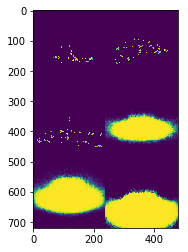

In [18]:
#Test using test set

os.chdir('E:/OneDrive/Py/SvJ')
eval_model.load_weights('model_v5_loc-89.h5')

#Evaluate model
y_pred, x_recon = eval_model.predict(x_test)
print('-'*50)
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.int64(y_test))/y_test.shape[0])


#Receptive field representation
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image

img = combine_images(np.concatenate([x_test[:4],x_recon[:4]]))
image = img * 255
Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
print()
print('Reconstructed images are saved to ./real_and_recon.png')
print('-'*50)
plt.imshow(plt.imread("real_and_recon.png", ))
plt.show()


Reconstructed images are saved to ./real_and_recon.png
--------------------------------------------------


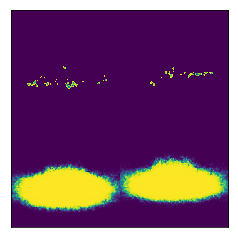

In [52]:
img = combine_images(np.concatenate([x_test[338:340],x_recon[338:340]]))
image = img * 255
Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
print()
print('Reconstructed images are saved to ./real_and_recon.png')
print('-'*50)
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,labelleft=False)
plt.imshow(plt.imread("real_and_recon.png", ))
plt.show()

In [41]:
y_test.shape

(350,)

## Create info for second layer

In [24]:
#Test using all set, to create outputs for second predictive layer

eval_model.load_weights('model_v5_loc-89.h5')

#Evaluate model
y_pred, x_recon = eval_model.predict(x_all)
print('Eval acc for trained-on and tested-on data (second-layer model should perform better than this):', np.sum(np.argmax(y_pred, 1) == np.int64(y_all))/y_all.shape[0])
# Typically = 
#np.savetxt('SvJ_allpred.csv', y_pred, delimiter=',')

NameError: name 'eval_model' is not defined

# Parse EM Metrics

In [10]:
#Create df with class predictions and true class labels
import pandas as pd

os.chdir(main_directory)

y_pred = np.genfromtxt('SvJ_allpred.csv', delimiter=',')
pred = pd.DataFrame(y_pred, columns = {'J', 'S'})
files = os.listdir('./SvJ_Loc/all/J') + os.listdir('./SvJ_Loc/all/S')
files = pd.DataFrame(files, columns={'File'})

df = pd.merge(files, pred, left_index=True, right_index=True)
df['TrueCat'] = np.int32(y_all)

#Split filename into P# and Img#

df['File'] = df['File'].str[:-8]
df['Split'] = df['File'].str.split('-')
df[['P','I']] = pd.DataFrame(df['Split'].values.tolist(), index=df.index)

df = df[df.P != 'A29']
df = df[df.P != 'A31']
df = df[df.P != 'B54']
df = df[df.P != 'B58']

df = df.set_index(['P','I','TrueCat'])
df.drop(['File','Split'], axis=1, inplace=True)

### Add EM Metrics to dataframe

Don't forget to merge to existing index (so non-used data is dropped)

##### Parse datafiles into df

In [11]:
os.chdir('./Parse/EMmetrics/')
df_em = pd.DataFrame().fillna(0)

# Read each file, add new column = I#
for i in os.listdir():
    df_stim = pd.read_csv(i, sep='\t', header=0, skipfooter=1)
    df_stim['I'] = i[2:5]
    if i[0] == 'J':
        df_stim['TrueCat'] = 1
    elif i[0] == 'S':
        df_stim['TrueCat'] = 0
    df_stim.columns = ['P','TFD','FC','I','TrueCat']
    df_stim.set_index(['P','I','TrueCat'], inplace=True)
    df_em = df_em.append(df_stim)

df = df.join(df_em, how='inner') #Matches both indexes, automatically drops missing from either

C:\Users\Mike\AppData\Local\conda\conda\envs\sci\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [12]:
df['TFD'] = (df['TFD'] / 10)

df['FC'] = (df['FC'] / 30)

In [13]:
df = df.reset_index()
df.head()

,P,I,TrueCat,S,J,TFD,FC
0,A01,003,0,0.959785,0.011401,0.386,0.500000
1,A01,003,1,0.046749,0.909975,0.033,0.066667
2,A01,004,0,0.930387,0.024842,0.239,0.233333
3,A01,004,1,0.012307,0.917852,0.043,0.066667
4,A01,005,0,0.933638,0.015366,0.375,0.400000


### Run ML for only metrics, compare to metrics+class_predictions

#### Linear regression



In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = df[['S','J','TFD','FC']] # 95.252%
#X = df[['S','J']] # 91.71%
#X = df[['TFD','FC']] #74.481%
y = df['TrueCat']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

lr = LogisticRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

accuracy_score(y_test,preds)

0.93170731707317078

#### SVM

In [258]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train,y_train)

preds = clf.predict(X_test)
accuracy_score(y_test,preds)

0.95609756097560972

#### 

#### Feed-forward NN (at least 2 layers of dropout in FC layer)

In [2]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

batch_size = 816
num_classes = 1
epochs = 200

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(4,)))
#model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='tanh'))

model.summary()


model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=0.005),
              metrics=['accuracy'])

model.fit(X_train.values, y_train.values,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test.values,y_test.values))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

NameError: name 'X_train' is not defined

In [259]:
score = model.evaluate(X_test.values, y_test.values, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0931713475687
Test accuracy: 0.970731707317
